# Regressing Clinical Measures from Video Data in Telepresence Interactions

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
import sklearn
import sklearn.linear_model as linr
import sklearn.model_selection as model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.ensemble as ensemble
import sklearn.tree as tree
import numpy as np
import tikzplotlib
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn import neighbors
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score

#Options
params = {'text.usetex' : True,
          'font.size' : 8,
          'font.family' : 'Computer Modern Roman',
          }
plt.rcParams.update(params) 

%matplotlib inline 

In [2]:
def fix_reps(results):
    subj_store=9999
    rep_count_left=0
    rep_count_right=0
    for idx in range(len(results)):
        subj=results.loc[idx,'subject']
        if not subj_store==subj:
            subj_store=subj
            rep_count_left=0
            rep_count_right=0
        side = results.loc[idx, 'side']
        if side=='right':
            results.loc[idx, 'rep']=rep_count_right
            rep_count_right += 1
        if side=='left':
            results.loc[idx, 'rep']=rep_count_left
            rep_count_left += 1    

In [3]:
def try_regression_models(features,labels, feature_names):
    model_coefs=pd.DataFrame(columns=['model']+feature_names)
    error_arr=[]

    for model_def in [('elasticnet', linr.ElasticNet()),('ridge',linr.Ridge()),
                      ('lasso',linr.Lasso()),('ransacregressor',linr.RANSACRegressor()),
                      ('adaboost',ensemble.AdaBoostRegressor()),
                      ('gradientboost',ensemble.GradientBoostingRegressor()),
                      ('decision_tree',tree.DecisionTreeRegressor())
                     ]:
        lm=model_def[1]
        name=model_def[0]
        pipeline=sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), lm)
        scores = model_selection.cross_validate(pipeline,  features,np.ravel(labels), scoring=('r2','neg_mean_absolute_error','neg_median_absolute_error'), cv=10, return_train_score=False)
        pipeline.fit(features,np.ravel(labels))
        try:
            coefs=pipeline.named_steps[name].coef_
            model_coefs=pd.concat([model_coefs, pd.DataFrame(np.atleast_2d(np.array([name]+list(coefs))),columns=['model']+feature_names)])
        except:
            pass
        mean_abs_error=np.mean(np.absolute(scores["test_neg_mean_absolute_error"]))
        median_abs_error=np.median(np.absolute(scores["test_neg_median_absolute_error"]))
        error_arr.append([name, mean_abs_error, median_abs_error])
#         print(f'model: {name}, MAE: {np.mean(np.absolute(scores["test_neg_mean_absolute_error"]))}, median absolute error: {np.median(np.absolute(scores["test_neg_median_absolute_error"]))}')
    errors=pd.DataFrame(error_arr, columns=['Model','Mean abs error', 'Median abs error'])
    return model_coefs, errors

## Simon Says (Reachable Workspace)

In [4]:
target_dir=pathlib.Path("/media/mjsobrep/43CDA61E672B9161/pose/")
results_ss=pd.read_csv(target_dir/"ss_ch-train.csv")

In [5]:
results_ss.replace(['R','L'],['right','left'],inplace=True)
fix_reps(results_ss)
results_ss

,Unnamed: 0,subject,rep,side,bbt,age,convex_hull,arm_length,norm_convex_hull,convex_hull_surface_area,convex_hull_surface_area_norm
0,0,23,0,right,-2.561644,4,3.142130e+07,276.305789,0.355603,5.564706e+05,0.580033
1,1,23,0,left,-1.034091,4,2.778608e+07,273.391793,0.324625,5.188112e+05,0.552368
2,2,23,1,right,-2.561644,4,3.938454e+08,1400.678772,0.034215,3.971678e+06,0.161097
3,3,23,1,left,-1.034091,4,3.656176e+08,940.832840,0.104810,3.922705e+06,0.352656
4,4,44,0,right,-10.169811,7,1.488394e+07,433.546605,0.043604,3.861540e+05,0.163485
...,...,...,...,...,...,...,...,...,...,...,...
83,83,20,1,left,-1.972973,81,6.219274e+08,785.249072,0.306640,5.541923e+06,0.715214
84,84,35,0,right,-1.085714,70,1.284149e+08,424.705996,0.400186,1.441247e+06,0.635846
85,85,35,0,left,-3.042857,70,7.304128e+07,392.227896,0.288978,1.007212e+06,0.520995
86,86,35,1,right,-1.085714,70,1.364190e+08,438.735563,0.385636,1.518769e+06,0.627879


In [6]:
results_ss['convex_hull'].max()/results_ss['convex_hull'].median()

682.3968869933886

<AxesSubplot:xlabel='age', ylabel='arm_length'>

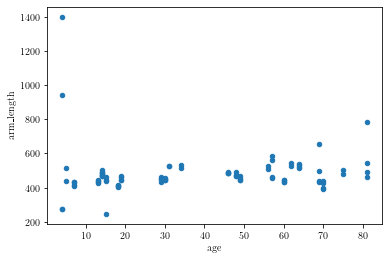

In [7]:
results_ss.plot("age", "arm_length", "scatter")

So a few outliers here, arm length is not perfect

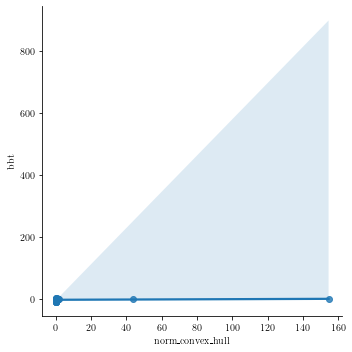

In [8]:
sns.lmplot(x='norm_convex_hull',y='bbt',data=results_ss,fit_reg=True) 

(-8.0, 5.0)

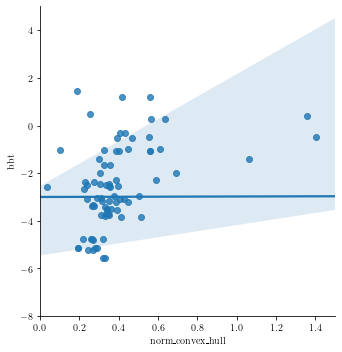

In [9]:
sns.lmplot(x='norm_convex_hull',y='bbt',data=results_ss,fit_reg=True) 
plt.xlim([0, 1.5])
plt.ylim([-8,5])

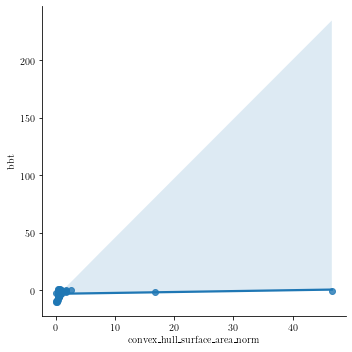

In [10]:
sns.lmplot(x='convex_hull_surface_area_norm',y='bbt',data=results_ss,fit_reg=True) 
# plt.xlim([0, 1.5])
# plt.ylim([-8,5])

(-8.0, 5.0)

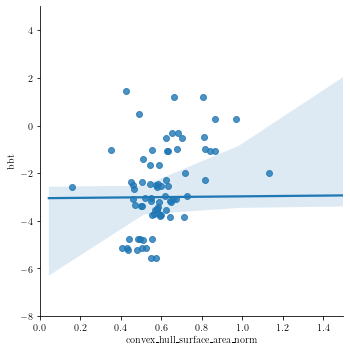

In [11]:
sns.lmplot(x='convex_hull_surface_area_norm',y='bbt',data=results_ss,fit_reg=True) 
plt.xlim([0, 1.5])
plt.ylim([-8,5])

In [12]:
bbt_vals=results_ss['bbt'].values.reshape(-1,1)
ch_vals=results_ss['norm_convex_hull'].values.reshape(-1,1)

In [13]:
reg=linr.LinearRegression().fit(ch_vals,bbt_vals)
print(f'bbt z-score={reg.coef_}*norm_convex_hull + {reg.intercept_} || R^2={reg.score(ch_vals,bbt_vals)}')

bbt z-score=[[0.01997192]]*norm_convex_hull + [-2.99946742] || R^2=0.019345634032068126


In [14]:
lm = linr.LinearRegression()
cv = model_selection.LeaveOneOut().split(results_ss) # leave one out doesn't work for linear regression with r^2
scores = model_selection.cross_val_score(lm,  ch_vals,bbt_vals, scoring='neg_mean_absolute_error', cv=cv)
print(f'MAE: {np.mean(np.absolute(scores))}, median absolute error: {np.median(np.absolute(scores))}')

MAE: 1.8119292423658215, median absolute error: 1.474844769294441


<AxesSubplot:ylabel='Count'>

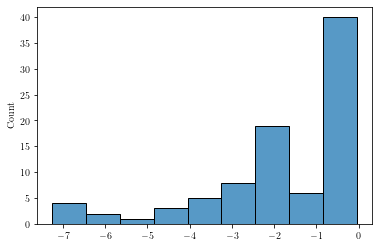

In [15]:
sns.histplot(scores)

Pretty bad performance. Outliers aren't helping. Let's try RANSAC

In [16]:
lm = linr.RANSACRegressor()
cv = model_selection.LeaveOneOut().split(results_ss) # leave one out doesn't work for linear regression with r^2
scores = model_selection.cross_val_score(lm,  ch_vals,bbt_vals, scoring='neg_mean_absolute_error', cv=cv)
print(f'MAE: {np.mean(np.absolute(scores))}, median absolute error: {np.median(np.absolute(scores))}')

MAE: 9.603655859648173, median absolute error: 1.5013547463314194


In [17]:
ss_feature_names=['norm_convex_hull','convex_hull_surface_area_norm']
ss_features=results_ss[ss_feature_names]
try_regression_models(ss_features, bbt_vals,ss_feature_names)

(        model     norm_convex_hull convex_hull_surface_area_norm
 0  elasticnet                  0.0                           0.0
 0       ridge  -2.1774533548642765             2.548785956854623
 0       lasso                  0.0                           0.0,
              Model  Mean abs error  Median abs error
 0       elasticnet        4.276633          1.835998
 1            ridge        3.116621          1.826094
 2            lasso        2.300226          1.835998
 3  ransacregressor       29.811832          1.583738
 4         adaboost        1.568482          0.843737
 5    gradientboost        1.718423          1.165532
 6    decision_tree        1.995131          1.363158)

<AxesSubplot:ylabel='Count'>

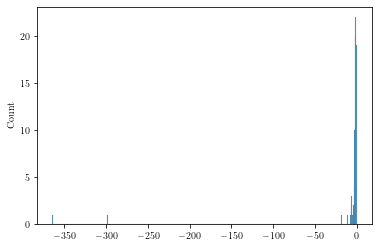

In [18]:
sns.histplot(scores)

(-10.0, 10.0)

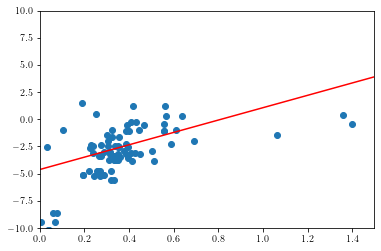

In [19]:
plt.scatter(ch_vals, bbt_vals)
lm.fit(ch_vals, bbt_vals)
xaxis = np.array([ch_vals.min(), ch_vals.max()])
yaxis = lm.predict(xaxis.reshape((len(xaxis), 1)))
plt.plot(xaxis,yaxis,'r')
plt.xlim([0, 1.5])
plt.ylim([-10,10])

MAE is worse with RANSAC, but the fit is obviously better. MAE might not be the best measure...

## Target Touch (Kinematics)

In [20]:
results_tt=pd.read_csv(target_dir/"tt_features-train.csv")
fix_reps(results_tt)
results_tt

,Unnamed: 0,subject,rep,side,bbt,age,max_speed,max_accel,max_jerk,avg_speed,...,time_to_max_speed_norm,time_to_max_accel,time_to_max_accel_norm,time_to_max_jerk,time_to_max_jerk_norm,length_movement_xyz,length_movement_t,normalized_jerk,speed_metric,number_movements
0,0,23,0,right,-2.561644,4,761.862490,3906.580363,36525.755213,2212.716316,...,0.523804,0.235194,0.269242,0.302361,0.461537,291.960020,0.671871,180730.507382,0.593398,33
1,1,23,0,left,-1.034091,4,942.022324,3953.494032,38389.849636,1985.458409,...,0.532737,0.436747,0.755953,0.335932,0.510000,346.562807,0.722285,213525.749539,0.615008,24
2,2,23,1,right,-2.561644,4,798.623359,5041.901007,42515.406678,2556.758405,...,0.499998,0.285380,0.488109,0.285385,0.439283,278.396045,0.604745,201752.208913,0.613961,42
3,3,23,1,left,-1.034091,4,837.528316,4250.915057,28060.373414,2303.252516,...,0.571428,0.437788,0.849384,0.268768,0.516676,352.303603,0.705058,149633.313657,0.636542,32
4,4,44,0,right,-10.169811,7,271.463669,381.506370,646.447668,180.676375,...,0.538464,1.075085,0.954546,1.377318,0.666668,377.844806,2.116419,11722.362343,0.768479,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,80,20,1,left,-1.972973,81,744.377258,3417.245365,34868.625396,2207.089924,...,0.464296,0.386365,0.469269,0.302373,0.425823,345.252402,0.755517,185031.573211,0.582434,16
81,81,35,0,right,-1.085714,70,749.805682,3914.391168,27379.458421,2190.066748,...,0.499543,0.134383,0.190474,0.302362,0.473535,288.498924,0.636641,133112.393902,0.612590,17
82,82,35,0,left,-3.042857,70,727.919043,3085.014781,22142.303545,1842.318223,...,0.533342,0.436469,0.772739,0.335964,0.562144,289.590901,0.721842,127625.489726,0.637210,18
83,83,35,1,right,-1.085714,70,763.451009,4333.035554,34005.128903,2362.008000,...,0.518520,0.436755,0.789474,0.369564,0.733333,288.103724,0.571134,174221.491894,0.636808,15


In [21]:
feature_names_tt=[
              'age',
              'max_speed',
              'max_accel',
              'max_jerk',
              'avg_speed',
              'avg_accel',
              'avg_jerk',
              'max_div_avg_speed',
              'max_div_avg_accel',
              'max_div_avg_jerk',
              'time_to_max_speed',
              'time_to_max_speed_norm',
              'time_to_max_accel',
              'time_to_max_accel_norm',
              'time_to_max_jerk',
              'time_to_max_jerk_norm',
              'length_movement_xyz',
              'length_movement_t',
              'normalized_jerk',
              'speed_metric',
              'number_movements']
clean_names_tt=[
              'Age (yrs)',
              'Max Speed (mm/s)',
              'Max Accel (mm/s$^{2}$)',
              'Max Jerk (mm/s$^{3}$)',
              'Avg Speed (mm/s)',
              'Avg Accel (mm/s$^{2}$)',
              'Avg Jerk (mm/s$^{3}$)',
              'Max Speed / Avg Speed',
              'Max Accel / Avg Accel',
              'Max Jerk / Avg Jerk',
              'Time To Max Speed (s)',
              'Time To Max Speed\nNormalized',
              'Time To Max Accel (s)',
              'Time To Max Accel\nNormalized',
              'Time To Max Jerk (s)',
              'Time To Max Jerk\nNormalized',
              'Arc Length (mm)',
              'Duration (s)',
              'Normalized Jerk',
              'Speed Metric',
              'Number of Movements']
features_tt=results_tt[feature_names_tt]
labels_tt=results_tt[['bbt']]

In [22]:
coef,err=try_regression_models(features_tt, labels_tt,feature_names_tt)

In [23]:
err

,Model,Mean abs error,Median abs error
0,elasticnet,1.739371,1.349370
1,ridge,1.776759,1.153961
2,lasso,1.821178,1.297717
3,ransacregressor,3.442913,2.216478
4,adaboost,1.853778,1.415215
5,gradientboost,1.947376,1.387395
6,decision_tree,2.425863,1.872757


In [24]:
coef

,model,age,max_speed,max_accel,max_jerk,avg_speed,avg_accel,avg_jerk,max_div_avg_speed,max_div_avg_accel,...,time_to_max_speed_norm,time_to_max_accel,time_to_max_accel_norm,time_to_max_jerk,time_to_max_jerk_norm,length_movement_xyz,length_movement_t,normalized_jerk,speed_metric,number_movements
0,elasticnet,0.0,0.1272399924206269,0.07993080016704367,0.0,0.12654637950732084,0.1265344256489376,0.0,-0.0,-0.0,...,0.0,-0.0,0.0,-0.057823421796634786,0.0,0.0,-0.0,0.0,-0.0,-0.0
0,ridge,0.2861748854470494,0.09809069707072915,-0.3348243950446556,0.5577677323267664,0.6530521816916858,0.6530521816916904,-0.4362390659688712,-0.21133385605105942,0.2469594791959896,...,0.4032835572054874,-0.4937366553905129,0.44283047729469194,-1.2487353522929514,0.0438852781079561,1.542674900623716,-0.42691392913333664,-0.5283260391981326,0.5994297313988949,-0.2638385215452745
0,lasso,0.0,0.0,0.0,0.0,0.02978785240946405,5.015595781836e-16,0.0,0.0,-0.0,...,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0


This is kinda cool. We can see from lasso that avg speed is the most important feature. Given that we are modeling specifically the box and block test score, that makes sense. 

Ridge, as expected, uses a bit of everything, probably over fitting, but performs well. 

Elastic net suggests max speed, max acceleration, average speed, average acceleration, and time to max jerk are important. 

The thing is that ransac, which is robust to outliers is producing a very poor result. Makes me concerned about how much these are training to those outliers

We can try to use ransac to find good values, then train with elastic net...

In [25]:
pipeline=sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), linr.RANSACRegressor())
# scores = model_selection.cross_validate(pipeline,  features,np.ravel(labels), scoring=('r2','neg_mean_absolute_error','neg_median_absolute_error'), cv=10, return_train_score=False)
pipeline.fit(features_tt,np.ravel(labels_tt))
ransac_inliers=pipeline.named_steps['ransacregressor'].inlier_mask_
print(f'From {len(labels_tt)}, RANSAC selects {np.sum(ransac_inliers)}')

From 85, RANSAC selects 52


Text(0.02, 0.5, 'Box and Block Test Z-Score')

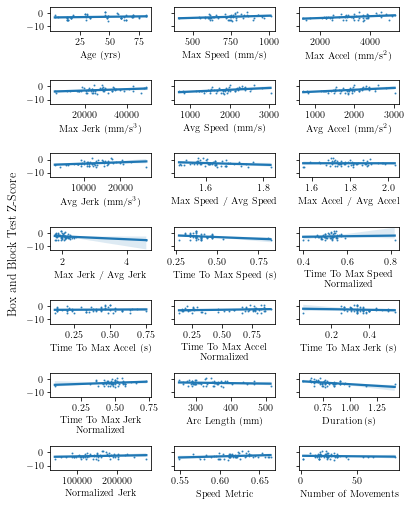

In [26]:
fig, axes = plt.subplots(7, 3, sharex=False, sharey=True, figsize=(5.8,7))
fig.tight_layout(rect=(0.05,0,1,1),h_pad=3)
inliers=results_tt[ransac_inliers]
for idx, feature in enumerate(feature_names_tt):
    p=sns.regplot(ax=axes.flatten()[idx],x=feature,y='bbt',data=inliers,fit_reg=True, scatter_kws={'s':1})
    p.set_xlabel(clean_names_tt[idx])
    p.set_ylabel('')
fig.supylabel('Box and Block Test Z-Score')
# plt.savefig(pathlib.Path.home()/'Downloads/kinematic_features-in.pgf', format='pgf')

## All together now

In [27]:
results_all=results_tt.merge(results_ss[['subject','side','rep','norm_convex_hull','convex_hull','convex_hull_surface_area','convex_hull_surface_area_norm']], on=['subject','side','rep'])
results_all

,Unnamed: 0,subject,rep,side,bbt,age,max_speed,max_accel,max_jerk,avg_speed,...,time_to_max_jerk_norm,length_movement_xyz,length_movement_t,normalized_jerk,speed_metric,number_movements,norm_convex_hull,convex_hull,convex_hull_surface_area,convex_hull_surface_area_norm
0,0,23,0,right,-2.561644,4,761.862490,3906.580363,36525.755213,2212.716316,...,0.461537,291.960020,0.671871,180730.507382,0.593398,33,0.355603,3.142130e+07,5.564706e+05,0.580033
1,1,23,0,left,-1.034091,4,942.022324,3953.494032,38389.849636,1985.458409,...,0.510000,346.562807,0.722285,213525.749539,0.615008,24,0.324625,2.778608e+07,5.188112e+05,0.552368
2,2,23,1,right,-2.561644,4,798.623359,5041.901007,42515.406678,2556.758405,...,0.439283,278.396045,0.604745,201752.208913,0.613961,42,0.034215,3.938454e+08,3.971678e+06,0.161097
3,3,23,1,left,-1.034091,4,837.528316,4250.915057,28060.373414,2303.252516,...,0.516676,352.303603,0.705058,149633.313657,0.636542,32,0.104810,3.656176e+08,3.922705e+06,0.352656
4,4,44,0,right,-10.169811,7,271.463669,381.506370,646.447668,180.676375,...,0.666668,377.844806,2.116419,11722.362343,0.768479,19,0.043604,1.488394e+07,3.861540e+05,0.163485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,80,20,1,left,-1.972973,81,744.377258,3417.245365,34868.625396,2207.089924,...,0.425823,345.252402,0.755517,185031.573211,0.582434,16,0.306640,6.219274e+08,5.541923e+06,0.715214
78,81,35,0,right,-1.085714,70,749.805682,3914.391168,27379.458421,2190.066748,...,0.473535,288.498924,0.636641,133112.393902,0.612590,17,0.400186,1.284149e+08,1.441247e+06,0.635846
79,82,35,0,left,-3.042857,70,727.919043,3085.014781,22142.303545,1842.318223,...,0.562144,289.590901,0.721842,127625.489726,0.637210,18,0.288978,7.304128e+07,1.007212e+06,0.520995
80,83,35,1,right,-1.085714,70,763.451009,4333.035554,34005.128903,2362.008000,...,0.733333,288.103724,0.571134,174221.491894,0.636808,15,0.385636,1.364190e+08,1.518769e+06,0.627879


In [28]:
feature_names_all = feature_names_tt+['norm_convex_hull','convex_hull','convex_hull_surface_area','convex_hull_surface_area_norm']
clean_names_all=clean_names_tt+['Reachable Workspace\nConvex Hull\nNormalized','Reachable Workspace\nConvex Hull','Reachable Workspace\nSurface Area','Reachable Workspace\nSurface Area\nNormalized']
features_all=results_all[feature_names_all]
labels_all=results_all[['bbt']]

In [29]:
coef, err=try_regression_models(features_all, labels_all, feature_names_all)

In [30]:
err.to_latex(pathlib.Path.home()/'Downloads/tables/regression_error.tex',
            index=False,
            float_format="%.2f" )
err

,Model,Mean abs error,Median abs error
0,elasticnet,4.366880,1.479066
1,ridge,7.010736,1.361730
2,lasso,2.150569,1.546733
3,ransacregressor,62.581834,2.464355
4,adaboost,1.390993,1.353327
5,gradientboost,1.419717,1.439894
6,decision_tree,1.887864,1.504512


In [31]:
coef.T.to_latex(pathlib.Path.home()/'Downloads/tables/regression_coef.tex',
            index=True,
            float_format="%.5f" )

In [32]:
coef.T

,0,0,0
model,elasticnet,ridge,lasso
age,0.0,0.32888551494039314,0.0
max_speed,0.10462068357589682,-0.1662284226202783,0.0
max_accel,0.0560169281659917,-0.24133827961247456,0.0
max_jerk,0.0,0.18785330230779404,0.0
avg_speed,0.12280474017859705,0.8083731962194689,0.0
avg_accel,0.1227930504334766,0.8083731962194693,0.0
avg_jerk,0.0,-0.4023090411296796,0.0
max_div_avg_speed,-0.0,-0.7644516282716136,0.0
max_div_avg_accel,-0.0,0.2311509062118169,-0.0


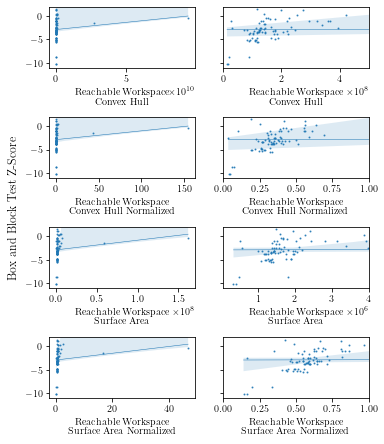

In [78]:
fig, axes = plt.subplots(4,2, sharex=False, sharey=True, figsize=(5.4,6))
fig.tight_layout(rect=(0.05,0,1,1),h_pad=3)
feature_names_rom=['convex_hull','norm_convex_hull','convex_hull_surface_area','convex_hull_surface_area_norm']
clean_names_rom=['Reachable Workspace\nConvex Hull','Reachable Workspace\nConvex Hull Normalized','Reachable Workspace\nSurface Area','Reachable Workspace\nSurface Area Normalized']
for limits in [True, False]:
    for idx, (feature, lim) in enumerate(zip(feature_names_rom,([0,500000000],[0,1],[50000,4000000],[0,1]))):
        p=sns.regplot(ax=axes.flatten(order='F')[idx+(4 if limits else 0)],x=feature,y='bbt',data=results_all,fit_reg=True, scatter_kws={'s':1}, line_kws={'linewidth':0.5})
        p.set_xlabel(clean_names_rom[idx])
        p.set_ylabel('')
        if limits:
            axes.flatten(order='F')[idx+(4 if limits else 0)].set_xlim(lim)
    
plt.ylim([-11,2])
fig.supylabel('Box and Block Test Z-Score')
plt.savefig(pathlib.Path.home()/'Downloads/rom_features.pdf', format='pdf',bbox_inches="tight")

Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring u

Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring u

Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring u

Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring u

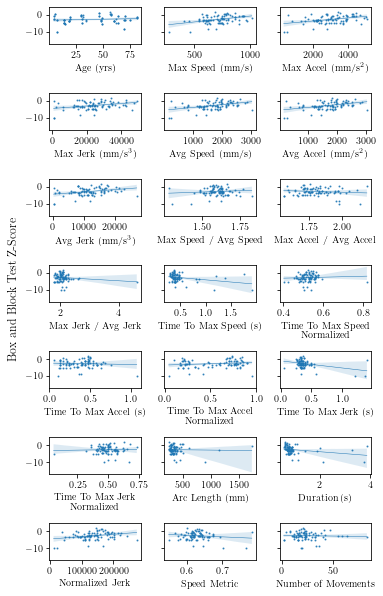

In [34]:
fig, axes = plt.subplots(7, 3, sharex=False, sharey=True, figsize=(5.4,8.25))
fig.tight_layout(rect=(0.05,0,1,1),h_pad=3)
for idx, feature in enumerate(feature_names_tt):
    p=sns.regplot(ax=axes.flatten()[idx],x=feature,y='bbt',data=results_all,fit_reg=True, scatter_kws={'s':1}, line_kws={'linewidth':0.5})
    p.set_xlabel(clean_names_all[idx])
    p.set_ylabel('')
fig.supylabel('Box and Block Test Z-Score')
plt.savefig(pathlib.Path.home()/'Downloads/kinematic_features.pgf', format='pgf',bbox_inches="tight")

We can see that with the addition of these last two values, things really go down the drain for the linear models, our weights just end up in the trash, but the boosted models actually get better. Yay boosting!!

## Selecting Features

Clearly the simon says data isn't getting us anywhere, so let's stick to the target touch data. 

In [35]:
limited_feature_names=[ 'max_speed','max_accel','avg_speed','avg_accel','time_to_max_jerk']
limited_features=results_tt[limited_feature_names]
labels=results_tt[['bbt']]
try_regression_models(limited_features, labels,limited_feature_names)

(        model            max_speed             max_accel            avg_speed  \
 0  elasticnet   0.1272399924206269   0.07993080016704367  0.12654637950732084   
 0       ridge  0.48717488826219024  -0.15556823926242655  0.28365233299132664   
 0       lasso                  0.0                   0.0  0.02978785240946405   
 
             avg_accel       time_to_max_jerk  
 0  0.1265344256489376  -0.057823421796634786  
 0  0.2836523329913289   -0.37761570687147755  
 0  5.015595781836e-16                   -0.0  ,
              Model  Mean abs error  Median abs error
 0       elasticnet        1.738116          1.349370
 1            ridge        1.835741          1.426770
 2            lasso        1.821178          1.297717
 3  ransacregressor        2.057460          1.917339
 4         adaboost        1.913352          1.170235
 5    gradientboost        2.019479          1.665771
 6    decision_tree        2.382222          1.783632)

In [36]:
feature_names=[ 'avg_speed']
features=results_tt[feature_names]
labels=results_tt[['bbt']]
try_regression_models(features, labels,feature_names)

(        model             avg_speed
 0  elasticnet   0.35319190160630964
 0       ridge    1.0178135750558661
 0       lasso  0.029787852409464553,
              Model  Mean abs error  Median abs error
 0       elasticnet        1.714965          1.205529
 1            ridge        1.681426          1.179516
 2            lasso        1.803396          1.228945
 3  ransacregressor        1.772689          1.535622
 4         adaboost        1.933106          1.606861
 5    gradientboost        2.139620          1.499963
 6    decision_tree        2.480269          1.765535)

Although paring down values doe improve the linear models, it does not improve the boosted models. We will be sticking with the boosted models...

## Classification

Thus far, we have attempted regression. Here we will try classification into 
no-low impairment, mild impairment, moderate impairment, and sever impairment. 

In [37]:
results_all
conditions=[
    (results_all['bbt']>-1),
    (results_all['bbt']<=-1) &(results_all['bbt']>-2),
    (results_all['bbt']<=-2) &(results_all['bbt']>-3),
    (results_all['bbt']<=-3),
]
choices=['no-impairment','mild-impairment','moderate-impairment','severe-impairment']
results_all['impairment']=np.select(conditions,choices)
results_all

,Unnamed: 0,subject,rep,side,bbt,age,max_speed,max_accel,max_jerk,avg_speed,...,length_movement_xyz,length_movement_t,normalized_jerk,speed_metric,number_movements,norm_convex_hull,convex_hull,convex_hull_surface_area,convex_hull_surface_area_norm,impairment
0,0,23,0,right,-2.561644,4,761.862490,3906.580363,36525.755213,2212.716316,...,291.960020,0.671871,180730.507382,0.593398,33,0.355603,3.142130e+07,5.564706e+05,0.580033,moderate-impairment
1,1,23,0,left,-1.034091,4,942.022324,3953.494032,38389.849636,1985.458409,...,346.562807,0.722285,213525.749539,0.615008,24,0.324625,2.778608e+07,5.188112e+05,0.552368,mild-impairment
2,2,23,1,right,-2.561644,4,798.623359,5041.901007,42515.406678,2556.758405,...,278.396045,0.604745,201752.208913,0.613961,42,0.034215,3.938454e+08,3.971678e+06,0.161097,moderate-impairment
3,3,23,1,left,-1.034091,4,837.528316,4250.915057,28060.373414,2303.252516,...,352.303603,0.705058,149633.313657,0.636542,32,0.104810,3.656176e+08,3.922705e+06,0.352656,mild-impairment
4,4,44,0,right,-10.169811,7,271.463669,381.506370,646.447668,180.676375,...,377.844806,2.116419,11722.362343,0.768479,19,0.043604,1.488394e+07,3.861540e+05,0.163485,severe-impairment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,80,20,1,left,-1.972973,81,744.377258,3417.245365,34868.625396,2207.089924,...,345.252402,0.755517,185031.573211,0.582434,16,0.306640,6.219274e+08,5.541923e+06,0.715214,mild-impairment
78,81,35,0,right,-1.085714,70,749.805682,3914.391168,27379.458421,2190.066748,...,288.498924,0.636641,133112.393902,0.612590,17,0.400186,1.284149e+08,1.441247e+06,0.635846,mild-impairment
79,82,35,0,left,-3.042857,70,727.919043,3085.014781,22142.303545,1842.318223,...,289.590901,0.721842,127625.489726,0.637210,18,0.288978,7.304128e+07,1.007212e+06,0.520995,severe-impairment
80,83,35,1,right,-1.085714,70,763.451009,4333.035554,34005.128903,2362.008000,...,288.103724,0.571134,174221.491894,0.636808,15,0.385636,1.364190e+08,1.518769e+06,0.627879,mild-impairment


In [38]:
def try_classification_models(features,labels, feature_names):
    scoring_techniques=['accuracy','balanced_accuracy','f1_weighted','f1_micro','f1_macro','roc_auc_ovo','roc_auc_ovo_weighted']
    score_arr=[]
#   All MLP using Relu  
    for model_def in [
        ('Gaussain Naive Bayes','', GaussianNB()),
        ('KNN','5 neighbors, distance weight', neighbors.KNeighborsClassifier(5, weights='distance')),
        ('KNN','10 neighbors, distance weight', neighbors.KNeighborsClassifier(10, weights='distance')),
        ('KNN','15 neighbors, distance weight', neighbors.KNeighborsClassifier(15, weights='distance')),
        ('KNN','5 neighbors, uniform weight', neighbors.KNeighborsClassifier(5, weights='uniform')),
        ('KNN','10 neighbors, uniform weight', neighbors.KNeighborsClassifier(10, weights='uniform')),
        ('KNN','15 neighbors, uniform weight', neighbors.KNeighborsClassifier(15, weights='uniform')),
        ('SGD','log loss, l1 penalty', SGDClassifier(loss="log", penalty="l1", max_iter=100, random_state=1)),
        ('SGD','log loss, l2 penalty', SGDClassifier(loss="log", penalty="l2", max_iter=100, random_state=1)),
        ('SGD','log loss, elastic penalty', SGDClassifier(loss="log", penalty="elasticnet", max_iter=100, random_state=1)),
        ('SGD','huber loss, l1 penalty', SGDClassifier(loss="modified_huber", penalty="l1", max_iter=100, random_state=1)),
        ('SGD','huber loss, l2 penaltly', SGDClassifier(loss="modified_huber", penalty="l2", max_iter=100, random_state=1)),
        ('SGD','huber loss, elastic penalty', SGDClassifier(loss="modified_huber", penalty="elasticnet", max_iter=100, random_state=1)),
        ('SVD','one-vs-one', svm.SVC(decision_function_shape='ovo', probability=True, random_state=1)),
        ('SVD','one-vs-rest', svm.SVC(decision_function_shape='ovr', probability=True, random_state=1)),
        ('MLP','layers: 2-2', MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(2, 2), random_state=1, max_iter=5000)),
        ('MLP','layers: 3-2', MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(3, 2), random_state=1, max_iter=5000)),
        ('MLP','layers: 2-3', MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(2, 3), random_state=1, max_iter=5000)),
        ('MLP','layers: 4-2', MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(4, 2), random_state=1, max_iter=5000)),
        ('MLP','layers: 2-2-2', MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(2, 2, 2), random_state=1, max_iter=5000)),
        ('MLP','layers: 2-2-2-2', MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(2, 2, 2, 2), random_state=1, max_iter=5000)),
        ('MLP','layers: layers: 2-2-2-2-2', MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(2, 2, 2, 2, 2), random_state=1, max_iter=5000)),
        ('MLP','layers: 3-3', MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(3, 3), random_state=1, max_iter=5000)),
        ('RandomForest','10 estimators', RandomForestClassifier(n_estimators=10, max_features='sqrt', random_state=1)),
        ('RandomForest','25 estimators', RandomForestClassifier(n_estimators=25, max_features='sqrt', random_state=1)),
        ('RandomForest','50 estimators', RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=1)),
        ('RandomForest','75 estimators', RandomForestClassifier(n_estimators=75, max_features='sqrt', random_state=1)),
        ('RandomForest','85 estimators', RandomForestClassifier(n_estimators=85, max_features='sqrt', random_state=1)),
        ('RandomForest','100 estimators', RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=1)),
        ('RandomForest','200 estimators', RandomForestClassifier(n_estimators=200, max_features='sqrt', random_state=1)),
        ('RandomForest','300 estimators', RandomForestClassifier(n_estimators=300, max_features='sqrt', random_state=1)),
        ('AdaBoost', '', AdaBoostClassifier())
    ]:
        lm=model_def[2]
        name=model_def[0]
        notes=model_def[1]
        pipeline=sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), lm)
        scores = model_selection.cross_validate(pipeline,  features,np.ravel(labels), scoring=scoring_techniques, cv=10, return_train_score=False)
        score_arr.append([name, notes]+[np.mean(scores[f'test_{k}']) for k in scoring_techniques])

#         print(f'model:{name}; {notes}, \nAccur: {np.mean(scores["test_accuracy"]):.2f}, Bal Accur: {np.mean(scores["test_balanced_accuracy"]):.2f}, F1 wghtd: {np.mean(scores["test_f1_weighted"]):.2f}, F1 mic: {np.mean(scores["test_f1_micro"]):.2f}, F1 mac: {np.mean(scores["test_f1_macro"]):.2f}, ROC 1v1 mac: {np.mean(scores["test_roc_auc_ovo"]):.2f}, ROC 1v1 wghtd: {np.mean(scores["test_roc_auc_ovo_weighted"]):.2f}')
#         print('\n')
    score_df=pd.DataFrame(score_arr,columns=(['name','details']+scoring_techniques))
    return score_df

alg_table=try_classification_models(features_all, results_all[['impairment']],feature_names)

In [39]:
def make_pretty(styler):
    styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="viridis")
    return styler
alg_table.to_latex(pathlib.Path.home()/'Downloads/tables/class_all.tex',
            index=False,
            float_format="%.2f" )
alg_table.style.pipe(make_pretty)

,name,details,accuracy,balanced_accuracy,f1_weighted,f1_micro,f1_macro,roc_auc_ovo,roc_auc_ovo_weighted
0,Gaussain Naive Bayes,,0.333333,0.328750,0.323221,0.333333,0.248690,0.595208,0.607454
1,KNN,"5 neighbors, distance weight",0.475000,0.352500,0.417674,0.475000,0.312632,0.552708,0.553976
2,KNN,"10 neighbors, distance weight",0.500000,0.300000,0.404468,0.500000,0.243321,0.563750,0.561626
3,KNN,"15 neighbors, distance weight",0.526389,0.312500,0.415720,0.526389,0.256894,0.586250,0.589039
4,KNN,"5 neighbors, uniform weight",0.426389,0.308750,0.382537,0.426389,0.262704,0.575833,0.578275
5,KNN,"10 neighbors, uniform weight",0.488889,0.293750,0.404617,0.488889,0.248333,0.565208,0.572263
6,KNN,"15 neighbors, uniform weight",0.477778,0.281250,0.380400,0.477778,0.226364,0.560208,0.571186
7,SGD,"log loss, l1 penalty",0.440278,0.402500,0.437986,0.440278,0.358254,0.623333,0.627245
8,SGD,"log loss, l2 penalty",0.452778,0.391250,0.415820,0.452778,0.310853,0.622396,0.641175
9,SGD,"log loss, elastic penalty",0.452778,0.370000,0.426647,0.452778,0.311627,0.633854,0.637963


Note, MLP with depth just gives random.

Random forests outperforms by a healty bit. Going with that.

In [40]:
# pipeline=sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), RandomForestClassifier())
# param_grid = {
#     'randomforestclassifier__max_depth': [None,1,2,3, 4, 5, 6, 7, 8, 9, 10],
#     'randomforestclassifier__min_samples_leaf': [1, 2, 3,4, 5],
#     'randomforestclassifier__min_samples_split': [2,3,4, 5, 6],
#     'randomforestclassifier__n_estimators': [30,40,50,60,70,80,90,100,110,120,130],
#     'randomforestclassifier__max_features': ['sqrt','log2',None],
#     'randomforestclassifier__random_state': [1]
# }
# # Fit the grid search model
# grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, 
#                           cv = 10, n_jobs = -1, verbose = 2, scoring='f1_macro')
# grid_search.fit(features_all,np.ravel(results_all[['impairment']]))

# # Fitting 10 folds for each of 9075 candidates, totalling 90750 fits
# # GridSearchCV(cv=10,
# #              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
# #                                        ('randomforestclassifier',
# #                                         RandomForestClassifier())]),
# #              n_jobs=-1,
# #              param_grid={'randomforestclassifier__max_depth': [None, 1, 2, 3, 4,
# #                                                                5, 6, 7, 8, 9,
# #                                                                10],
# #                          'randomforestclassifier__max_features': ['sqrt',
# #                                                                   'log2',
# #                                                                   None],
# #                          'randomforestclassifier__min_samples_leaf': [1, 2, 3,
# #                                                                       4, 5],
# #                          'randomforestclassifier__min_samples_split': [2, 3, 4,
# #                                                                        5, 6],
# #                          'randomforestclassifier__n_estimators': [30, 40, 50,
# #                                                                   60, 70, 80,
# #                                                                   90, 100, 110,
# #                                                                   120, 130],
# #                          'randomforestclassifier__random_state': [1]},
# #              verbose=2)


# grid_search.best_estimator_
# # Pipeline(steps=[('standardscaler', StandardScaler()),
# #                 ('randomforestclassifier',
# #                  RandomForestClassifier(max_depth=7, max_features='sqrt',
# #                                         n_estimators=50, random_state=1))])

# grid_search.best_score_
# # 0.4841666666666667



In [41]:
pipeline=sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=50,max_depth=7, max_features='sqrt', random_state=1))
pipeline.fit(features_all,np.ravel(results_all[['impairment']]))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=50, random_state=1))])

In [42]:
per_importances = permutation_importance(pipeline, features_all,np.ravel(results_all[['impairment']]), n_repeats=50,n_jobs=-1,scoring='f1_macro',random_state=1)

In [62]:
importance_tbl=pd.DataFrame([clean_names_all, per_importances.importances_mean, per_importances.importances_std] ).T
importance_tbl.columns=['Feature','Training Importance Mean', 'SD' ]
importance_tbl_sorted=importance_tbl.sort_values('Training Importance Mean',ascending=False)
importance_tbl_sorted


,Feature,Training Importance Mean,SD
18,Normalized Jerk,0.019017,0.008533
8,Max Accel / Avg Accel,0.016036,0.009018
10,Time To Max Speed (s),0.014385,0.009544
16,Arc Length (mm),0.012828,0.005176
22,Reachable Workspace\nConvex Hull,0.011404,0.008357
12,Time To Max Accel (s),0.011337,0.006371
23,Reachable Workspace\nSurface Area,0.011335,0.009425
0,Age (yrs),0.009508,0.006251
17,Duration (s),0.009306,0.004653
6,Avg Jerk (mm/s$^{3}$),0.009248,0.00724


In [67]:
importance_tbl_sorted.to_latex(pathlib.Path.home()/'Downloads/tables/importance_tbl.tex',
            index=False,
            float_format="{:0.3f}".format )

# Test

In [44]:
target_dir=pathlib.Path("/media/mjsobrep/43CDA61E672B9161/pose/")
results_ss_test=pd.read_csv(target_dir/"ss_ch-test.csv")
results_ss_test.replace(['R','L'],['right','left'],inplace=True)
fix_reps(results_ss_test)
results_tt_test=pd.read_csv(target_dir/"tt_features-test.csv")
fix_reps(results_tt_test)
results_all_test=results_tt_test.merge(results_ss_test[['subject','side','rep','norm_convex_hull','convex_hull','convex_hull_surface_area','convex_hull_surface_area_norm']], on=['subject','side','rep'])
conditions_test=[
    (results_all_test['bbt']>-1),
    (results_all_test['bbt']<=-1) &(results_all_test['bbt']>-2),
    (results_all_test['bbt']<=-2) &(results_all_test['bbt']>-3),
    (results_all_test['bbt']<=-3),
]
results_all_test['impairment']=np.select(conditions_test,choices)

In [45]:
results_all_test[['impairment']].value_counts()

impairment         
severe-impairment      12
moderate-impairment    10
mild-impairment         4
no-impairment           4
dtype: int64

In [46]:
predictions=pipeline.predict(results_all_test[feature_names_all])
true_vals=results_all_test[['impairment']]

In [47]:
f1_score(true_vals,predictions,average='macro')

0.11111111111111112

In [71]:
balanced_accuracy_score(true_vals,predictions,adjusted=False)

0.125

In [48]:
test_results=pd.concat([true_vals.T,pd.DataFrame(np.atleast_2d(predictions))]).T
test_results.columns=['True Impairment', 'Predicted Impairment']
test_results

,True Impairment,Predicted Impairment
0,severe-impairment,moderate-impairment
1,severe-impairment,no-impairment
2,severe-impairment,severe-impairment
3,severe-impairment,no-impairment
4,moderate-impairment,mild-impairment
5,moderate-impairment,mild-impairment
6,moderate-impairment,no-impairment
7,moderate-impairment,mild-impairment
8,severe-impairment,severe-impairment
9,severe-impairment,severe-impairment


In [59]:
confusion_matrix(true_vals,predictions,labels=choices)

array([[0, 1, 0, 3],
       [3, 0, 0, 1],
       [2, 3, 0, 5],
       [4, 0, 2, 6]])

Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring unknown font: Computer Modern Roman
Ignoring u

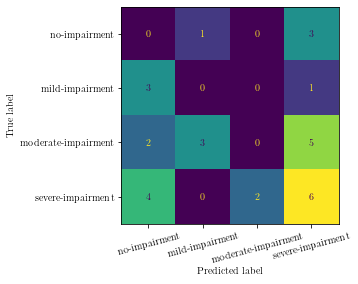

In [60]:
ConfusionMatrixDisplay.from_predictions(true_vals,predictions,xticks_rotation=15,labels=choices,colorbar=False)
plt.savefig(pathlib.Path.home()/'Downloads/test-confusion.pgf', format='pgf',bbox_inches="tight")

In [74]:
14/30

0.4666666666666667

In [75]:
14+6+10

30